In [172]:
!pip install -q crewai langchain langchain_core langchain_community langchain-openai wikipedia tavily-python langgraph

In [173]:
from pydantic import BaseModel, Field
from typing import List, Optional, TypedDict, Any

class EmailRequest(BaseModel):
    recipient_name: str = Field(..., description="The full name of the email recipient.")
    recipient_email: str = Field(..., description="The email address of the recipient.")
    subject: str = Field(..., description="The subject line of the email.")
    message_context: str = Field(..., description="The context or body content of the email.")

class EmailBodySchema(BaseModel):
    email_body: str = Field(..., description="The initial generated email body based on the original email's context and response requirements.")
    subject: str = Field(..., description="The subject of the email response, reflecting both the original email and response purpose.")
    key_points_covered: bool = Field(..., description="Indicates whether the key points from the original email have been addressed in the response.")
    word_count: int = Field(..., description="The total word count of the email body, ensuring the response is within optimal length.")
    sentiment_analysis_score: float = Field(..., description="Sentiment analysis score of the email body (range 0.0-1.0) indicating positive or negative sentiment of the response.")
    original_tone_reflected: bool = Field(..., description="Indicates whether the response matches or adapts the tone of the original email.")

class PersonalizedEmailSchema(BaseModel):
    personalized_email: str = Field(..., description="The email content personalized with the recipient's details, including name and relevant response context.")
    personalized_greeting: str = Field(..., description="The personalized greeting for the email, tailored to the recipient's name and context of the original email.")
    personalized_sign_off: str = Field(..., description="The personalized sign-off at the end of the email, including the sender's name and position.")
    recipient_email: str = Field(..., description="The recipient's email address, ensuring it matches the original email sender for proper response delivery.")
    language_style: str = Field(..., description="The language style used in the response, e.g., formal, semi-formal, or casual, adjusted based on the original email.")
    recipient_preferences_adapted: bool = Field(..., description="Indicates whether the email response has been adapted to the recipient's preferences, such as tone or communication style, based on the original email.")

class SuggestionsSchema(BaseModel):
    suggestions: List[str] = Field(..., description="A list of suggestions for improving the response email content, such as enhancing tone, structure, or clarity.")
    improvement_areas: List[str] = Field(..., description="Specific areas of the email response content that can be improved, e.g., better alignment with the original email's tone or more concise points.")
    grammar_check: bool = Field(..., description="Indicates whether a grammar check has been performed and any errors identified in the response.")
    engagement_score_prediction: float = Field(..., description="Prediction score (range 0.0-1.0) for how engaging the email response will be to the recipient, based on the content analysis.")
    readability_score: float = Field(..., description="Readability score of the email response (range 0.0-1.0), assessing how easy it is for the recipient to read and understand the response.")

class FinalEmailSchema(BaseModel):
    final_email_response: str = Field(..., description="The finalized version of the response email content after incorporating suggestions and ensuring all necessary details are covered.")
    subject: str = Field(..., description="The final subject of the response email, aligned with both the original email and the response content.")
    tone_achieved: str = Field(..., description="The final tone achieved in the response after revisions, ensuring it matches or adapts to the original email's tone.")
    call_to_action_included: bool = Field(..., description="Indicates whether the response includes a clear call to action for the recipient to take.")
    final_word_count: int = Field(..., description="The total word count of the finalized response email, ensuring it stays within optimal length.")
    final_sentiment_analysis_score: float = Field(..., description="Final sentiment analysis score (range 0.0-1.0) after incorporating revisions, assessing the emotional tone of the response.")
    original_email_responded_to: bool = Field(..., description="Indicates whether the response fully addresses the key points and context of the original email.")

class EmailOutput(BaseModel):
    generated_email: str = Field(..., description="The initial generated response email content based on the original email and provided context.")
    suggestions: List[str] = Field(..., description="The list of suggestions generated for improving the response email content.")
    final_email_improved: str = Field(..., description="The finalized version of the response email, ready to be sent after incorporating suggestions and improvements.")
    email_success_prediction: float = Field(..., description="A prediction score (0.0-1.0) indicating the likelihood of the response email achieving its intended goal, such as prompting further action or response from the recipient.")
    open_rate_prediction: float = Field(..., description="A prediction score (0.0-1.0) indicating the likelihood of the recipient opening the response email, based on the subject line and context.")
    click_through_rate_prediction: float = Field(..., description="A prediction score (0.0-1.0) estimating the likelihood of the recipient clicking any links or taking action based on the response email content.")
    recipient_engagement_likelihood: float = Field(..., description="A prediction score (0.0-1.0) assessing the likelihood of the recipient engaging with the response email, such as replying or following the suggested call to action.")

class GraphState(TypedDict):
    recipient_name: str
    recipient_email: str
    subject: str
    message_context: str

    email_body: EmailBodySchema
    personalized_email: PersonalizedEmailSchema
    suggestions: SuggestionsSchema
    final_email: FinalEmailSchema

    email_output: Any

In [174]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [175]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["SERPAPI_API_KEY"] = userdata.get("SERPAPI_API_KEY")

In [188]:
from crewai import Agent
from textwrap import dedent
from langchain_openai import ChatOpenAI
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import Tool
from langchain_community.tools import TavilySearchResults
from langchain_community.utilities import SerpAPIWrapper

class CustomAgents:
    def __init__(self):
        self.OpenAIGPT4Mini = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        self.OpenAIGPT4 = ChatOpenAI(model="gpt-4o", temperature=0)
        self.tools = [Tool(
                          name="Wikipedia",
                          func=WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run,
                          description="Useful for when you need to answer questions about current events. You should ask targeted questions."
                      ),
                      TavilySearchResults(
                        max_results=5,
                        include_answer=True,
                        include_raw_content=True
                      ),
                      Tool(
                          name="SerpAPI",
                          func=SerpAPIWrapper().run,
                          description="Useful for when you need to search for external info. in the Internet."
                      )]

    def content_agent(self):
        # Agent 1: Email Content Generator
        return Agent(
            role="Email Content Generator",
            backstory=dedent("""
                You are an expert at crafting engaging and appropriate email content based on provided context.
            """),
            goal=dedent("""
                Generate a draft email based on the given message context, ensuring the content aligns with the intended purpose.
            """),
            tools=self.tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4Mini,
        )

    def review_agent(self):
        # Agent 2: Email Reviewer
        return Agent(
            role="Email Reviewer",
            backstory=dedent("""
                You specialize in reviewing email content for tone, grammar, and clarity.
            """),
            goal=dedent("""
                Review the draft email, make improvements to grammar and tone, and ensure clarity.
            """),
            tools=self.tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

    def personalization_agent(self):
        # Agent 3: Personalization Specialist
        return Agent(
            role="Personalization Specialist",
            backstory=dedent("""
                You excel at adding personalized touches to emails based on recipient information.
            """),
            goal=dedent("""
                Personalize the email by adding relevant details about the recipient to make the message more engaging.
            """),
            tools=self.tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4Mini,
        )

    def output_agent(self):
        # Agent 4: Output Compiler
        return Agent(
            role="Output Compiler",
            backstory=dedent("""
                You are responsible for compiling the final email output, ensuring all elements are cohesive.
            """),
            goal=dedent("""
                Compile the final version of the email, incorporating all revisions and personalizations.
            """),
            tools=self.tools,
            allow_delegation=False,
            verbose=True,
            llm=self.OpenAIGPT4,
        )

In [189]:
from crewai import Task
from textwrap import dedent

class CustomTasks:
    def __init__(self):
        pass

    def content_task(self, agent, email_request: FinalEmailSchema):
        return Task(
            description=dedent(f"""
                Improve the draft email response based on the original email context and incorporate any necessary changes.

                **Original Email Context**:

                [The original email message that was received.]

                **Response Email Content**:
                {email_request.final_email_response}

                **Subject**:
                {email_request.subject}

                Ensure that the response email addresses the key points of the original email and has a clear subject.
            """),
            agent=agent,
            expected_output="A revised draft of the response email, improving on the initial draft while keeping the original email in focus."
        )

    def review_task(self, agent, email_request: FinalEmailSchema):
        return Task(
            description=dedent(f"""
                Review the draft email response for tone, grammar, and clarity. Ensure the response is professional, well-structured, and aligns with the original email's tone.

                **Email Draft**:
                {email_request.final_email_response}

                **Subject**:
                {email_request.subject}

                **Tone Achieved**:
                {email_request.tone_achieved}

                Make sure the email maintains the intended tone and responds to the original email appropriately.
            """),
            agent=agent,
            expected_output="A reviewed version of the email response, with improvements to tone, grammar, and clarity."
        )

    def personalization_task(self, agent, email_request: FinalEmailSchema):
        return Task(
            description=dedent(f"""
                Personalize the email response for the recipient based on the original email context and their specific preferences.

                **Email Response**:
                {email_request.final_email_response}

                **Recipient Information**:
                [Details about the recipient, such as their preferences.]

                **Call to Action Included**:
                {email_request.call_to_action_included}

                Ensure the response is engaging, personalized to the recipient, and contains a clear call to action.
            """),
            agent=agent,
            expected_output="A personalized version of the response email that addresses the recipient's context and includes a call to action."
        )

    def output_task(self, agent, email_request: FinalEmailSchema):
        email_output_schema = FinalEmailSchema.schema_json(indent=2)
        return Task(
            description=dedent(f"""
                Compile the final version of the email response, ensuring it incorporates all necessary revisions and personalizations, and is ready to be sent.

                **Final Email Content**:
                {email_request.final_email_response}

                **Subject**:
                {email_request.subject}

                **Final Word Count**:
                {email_request.final_word_count}

                Ensure the final email is within the optimal word length, properly responds to the original email, and matches the required format.
                You must give the response in JSON format according to the schema below:

                **Format**:
                {email_output_schema}
            """),
            agent=agent,
            expected_output=f"The finalized email response, ready for sending, in JSON format matching the schema: {email_output_schema}."
        )

In [178]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser

In [179]:
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

In [190]:
def generate_email_body(state):
    json_parser = JsonOutputParser(pydantic_object=EmailBodySchema)
    messages = [
        SystemMessage(content="You are an assistant that generates professional email responses based on the content of the original email and the provided context."),
        HumanMessage(content=f"""Please generate an email response based on the following original email and context:

    Original Email Context:
    {state['message_context']}

    Subject:
    {state['subject']}

    Ensure your response addresses the key points of the original email and follows the format and requirements specified in {json_parser.get_format_instructions()}.""")
    ]
    result = llm.invoke(messages)
    parsed_result = json_parser.parse(result.content)
    print(f"STEP 1 - GENERATE EMAIL RESPONSE BODY: {parsed_result}")
    return {"email_body": parsed_result}

def personalize_email(state):
    json_parser = JsonOutputParser(pydantic_object=PersonalizedEmailSchema)
    messages = [
        SystemMessage(content="You are an assistant that personalizes content based on the email's body."),
        HumanMessage(content=f"""Please personalize the following email's body:

    Email Response Body:
    {state['email_body']}

    Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.""")
    ]
    result = llm.invoke(messages)
    parsed_result = json_parser.parse(result.content)
    print(f"STEP 2 - PERSONALIZE EMAIL RESPONSE: {parsed_result}")
    return {"personalized_email": parsed_result}

def suggest_improvements(state):
    json_parser = JsonOutputParser(pydantic_object=SuggestionsSchema)
    messages = [
        SystemMessage(content="You are an assistant that suggests improvements to email response content."),
        HumanMessage(content=f"""Please provide suggestions to improve the following email response:

    Email Response Content:
    {state['personalized_email']}

    Ensure your suggestions focus on enhancing clarity, tone, and overall effectiveness. Follow the format and requirements specified in {json_parser.get_format_instructions()}.""")
    ]
    result = llm.invoke(messages)
    parsed_result = json_parser.parse(result.content)
    print(f"STEP 3 - SUGGEST IMPROVEMENTS TO EMAIL RESPONSE: {parsed_result}")
    return {"suggestions": parsed_result}

def finalize_email(state):
    json_parser = JsonOutputParser(pydantic_object=FinalEmailSchema)
    messages = [
        SystemMessage(content="You are an assistant that finalizes email responses by applying suggestions for improvement."),
        HumanMessage(content=f"""Please apply the following suggestions to improve the email response content:

    Email Response Content:
    {state['personalized_email']}

    Suggestions:
    {state['suggestions']}

    Ensure your response follows the format and requirements specified in {json_parser.get_format_instructions()}.""")
    ]
    result = llm.invoke(messages)
    parsed_result = json_parser.parse(result.content)
    print(f"STEP 4 - FINALIZE EMAIL RESPONSE: {parsed_result}")
    return {"final_email": parsed_result}

In [191]:
from crewai import Crew

class EmailGeneratorCrew:
    def __init__(self):
        self.agents = CustomAgents()
        self.tasks = CustomTasks()

    def kickoff(self, state):

        content_agent = self.agents.content_agent()
        review_agent = self.agents.review_agent()
        personalization_agent = self.agents.personalization_agent()
        output_agent = self.agents.output_agent()

        final_email_result = FinalEmailSchema(**state["final_email"])

        content_task = self.tasks.content_task(content_agent, final_email_result)
        review_task = self.tasks.review_task(review_agent, final_email_result)
        personalization_task = self.tasks.personalization_task(personalization_agent, final_email_result)
        output_task = self.tasks.output_task(output_agent, final_email_result)

        crew = Crew(
            agents=[
                content_agent,
                review_agent,
                personalization_agent,
                output_agent,
            ],
            tasks=[
                content_task,
                review_task,
                personalization_task,
                output_task,
            ],
            verbose=True,
        )

        result = crew.kickoff()

        return {**state, "email_output": result}

In [182]:
!pip install google-search-results

In [192]:
workflow = StateGraph(GraphState)

workflow.add_node("generate_email_body", generate_email_body)
workflow.add_node("personalize_email", personalize_email)
workflow.add_node("suggest_improvements", suggest_improvements)
workflow.add_node("finalize_email", finalize_email)
workflow.add_node("generate_improved_email", EmailGeneratorCrew().kickoff)

workflow.set_entry_point("generate_email_body")
workflow.add_edge("generate_email_body", "personalize_email")
workflow.add_edge("personalize_email", "suggest_improvements")
workflow.add_edge("suggest_improvements", "finalize_email")
workflow.add_edge("finalize_email", "generate_improved_email")
workflow.add_edge("generate_improved_email", END)

app = workflow.compile()

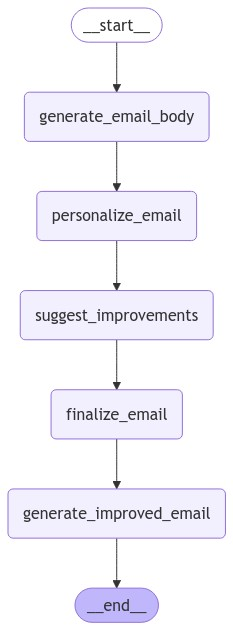

In [193]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [185]:
inputs = {
    "recipient_name": "John Doe",
    "recipient_email": "john.doe@example.com",
    "subject": "LLM Integration Strategy: Next Steps and Technical Roadmap",
    "message_context": """
    Hi John,

    Thank you for attending the meeting today on the potential integration of Large Language Models (LLMs) into your company’s workflows. It was insightful to explore how LLMs could enhance your customer service automation and streamline internal data processing.

    As discussed, here are the next steps moving forward:
    - **Data Preparation**: We will need to assess the existing data sets to ensure they are compatible with the LLM training pipeline. Our data team will send over a data audit checklist by Thursday for your review.
    - **LLM Model Selection**: Based on your company’s needs, we recommend starting with GPT-4 for customer service and Google Gemini for internal knowledge management. We’ll schedule a call next Tuesday to discuss the specific capabilities of these models and align them with your business goals.
    - **Integration Timeline**: The initial phase of integration will begin by November 1st, focusing on a pilot deployment within your customer service chatbot. A detailed roadmap is attached outlining the major milestones and expected outcomes.

    Please feel free to reach out if you have any questions or need further clarification before our next meeting. We’re excited to see how LLMs will transform your business operations!

    Best regards,
    Wilfredo Sosa
    AI Solutions Architect at XYZ Innovations
    """}

result = app.invoke(inputs)

STEP 1 - GENERATE EMAIL RESPONSE BODY: {'email_body': "Hi Wilfredo,\n\nThank you for the detailed summary and next steps regarding the integration of LLMs into our workflows. I appreciate the insights shared during the meeting, and I am looking forward to collaborating on this exciting project.\n\nI will ensure that our team reviews the data audit checklist once it's received on Thursday. Regarding the model selection, GPT-4 and Google Gemini sound like excellent choices, and I’m eager to discuss their specific capabilities in our call next Tuesday.\n\nThe integration timeline looks good, and I’m pleased to see the pilot deployment set to commence by November 1st. I will review the attached roadmap and come prepared with any questions.\n\nIf any additional information arises before our next meeting, I will reach out. Thank you once again for your guidance, and I share your enthusiasm for transforming our operations with LLMs!\n\nBest,\nJohn", 'subject': 'Re: LLM Integration Strategy: N

STEP 4 - FINALIZE EMAIL RESPONSE: {'final_email_response': 'Hi Wilfredo,\n\nThank you for the comprehensive overview and next steps regarding the integration of LLMs into our workflows. Your insights during the meeting were invaluable, and I am genuinely excited about collaborating on this transformative project.\n\nTo recap our discussion:\n- We will be reviewing the data audit checklist upon its arrival on Thursday.\n- The model options of GPT-4 and Google Gemini seem promising, and I’m looking forward to exploring their specific capabilities in our upcoming call next Tuesday.\n- The proposed integration timeline is encouraging, especially with the pilot deployment scheduled to begin by November 1st.\n\nI will coordinate with our team to ensure we review the attached roadmap thoroughly, and I’ll come prepared with any questions I might have.\n\nIf any additional information arises before our next meeting, I will reach out. I appreciate your guidance, and I share your enthusiasm for l

In [187]:
result

{'recipient_name': 'John Doe',
 'recipient_email': 'john.doe@example.com',
 'subject': 'LLM Integration Strategy: Next Steps and Technical Roadmap',
 'message_context': '\n    Hi John,\n\n    Thank you for attending the meeting today on the potential integration of Large Language Models (LLMs) into your company’s workflows. It was insightful to explore how LLMs could enhance your customer service automation and streamline internal data processing.\n\n    As discussed, here are the next steps moving forward:\n    - **Data Preparation**: We will need to assess the existing data sets to ensure they are compatible with the LLM training pipeline. Our data team will send over a data audit checklist by Thursday for your review.\n    - **LLM Model Selection**: Based on your company’s needs, we recommend starting with GPT-4 for customer service and Google Gemini for internal knowledge management. We’ll schedule a call next Tuesday to discuss the specific capabilities of these models and align t

In [194]:
inputs = {
    "recipient_name": "Jane Smith",
    "recipient_email": "jane.smith@example.com",
    "subject": "Request for Detailed Information on Large Language Models (LLMs)",
    "message_context": """
    Hi Jane,

    I hope this message finds you well.

    Following our recent discussion on Large Language Models (LLMs), I wanted to request more specific information regarding various aspects of LLMs that could benefit your organization. In particular, we would appreciate details on the following:

    - **Model Capabilities**: Could you provide more information on the key strengths of GPT-4, Google Gemini, and any other LLMs that would suit enterprise-level applications like customer service automation and internal data analysis?
    - **Customization Options**: How flexible are these models in terms of fine-tuning and integrating with existing workflows? Are there any specific API options we should be aware of for seamless integration?
    - **Training Data Requirements**: What are the best practices for preparing proprietary data to optimize LLM training and ensure alignment with company-specific needs? Additionally, what are the ideal data formats and volumes required to achieve high performance?
    - **Cost Considerations**: Could you provide a breakdown of the estimated costs involved in deploying and maintaining these LLMs, especially for large-scale use cases like real-time customer interaction?

    We are in the process of drafting a technical roadmap, and your insights will be invaluable as we move forward with selecting and deploying the most suitable LLM for our goals.

    Please let me know if you need any additional context or further details from our side.

    Looking forward to your input!

    Best regards,
    Wilfredo Sosa
    AI Solutions Architect at XYZ Innovations
    """
}
result2 = app.invoke(inputs)

STEP 1 - GENERATE EMAIL RESPONSE BODY: {'email_body': 'Hi Wilfredo,\n\nThank you for reaching out and for your interest in Large Language Models. I appreciate the specific areas you’ve highlighted for further discussion. Here are the details you requested:\n\n- **Model Capabilities**: GPT-4 excels in natural language understanding and generation, making it well-suited for customer service automation. Google Gemini also offers robust capabilities, particularly in understanding context and providing relevant responses. Both models can support internal data analysis, though they have different strengths in handling specialized queries.\n\n- **Customization Options**: Both models provide flexible customization options. GPT-4 allows for fine-tuning through its API, making it easier to integrate with existing workflows. Google Gemini also offers API integration, enabling seamless implementation tailored to your specific needs.\n\n- **Training Data Requirements**: To optimize LLM training, it

STEP 4 - FINALIZE EMAIL RESPONSE: {'final_email_response': "Hi Wilfredo,\n\nThank you for reaching out and expressing your keen interest in Large Language Models. I truly appreciate the specific areas you’ve highlighted for further discussion. Below is a brief overview of the details you requested:\n\n- **Model Capabilities**: \n  - **GPT-4** excels in natural language understanding and generation, making it well-suited for customer service automation. \n  - **Google Gemini** also offers robust capabilities, particularly in understanding context and providing relevant responses. \n  - Both models can support internal data analysis, though they have different strengths in handling specialized queries.\n\n- **Customization Options**: \n  - Both models provide flexible customization options. \n  - GPT-4 allows for fine-tuning through its API, making it easier to integrate with existing workflows. \n  - Google Gemini also offers API integration, enabling seamless implementation tailored to

In [195]:
result2

{'recipient_name': 'Jane Smith',
 'recipient_email': 'jane.smith@example.com',
 'subject': 'Request for Detailed Information on Large Language Models (LLMs)',
 'message_context': '\n    Hi Jane,\n\n    I hope this message finds you well.\n\n    Following our recent discussion on Large Language Models (LLMs), I wanted to request more specific information regarding various aspects of LLMs that could benefit your organization. In particular, we would appreciate details on the following:\n\n    - **Model Capabilities**: Could you provide more information on the key strengths of GPT-4, Google Gemini, and any other LLMs that would suit enterprise-level applications like customer service automation and internal data analysis?\n    - **Customization Options**: How flexible are these models in terms of fine-tuning and integrating with existing workflows? Are there any specific API options we should be aware of for seamless integration?\n    - **Training Data Requirements**: What are the best pr